In [4]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/img-dataset-dl/img_test_1.png
/kaggle/input/img-dataset-dl/img_test_6.png
/kaggle/input/img-dataset-dl/img_test_5.png
/kaggle/input/img-dataset-dl/img_test_2.png
/kaggle/input/img-dataset-dl/img_test_4.png
/kaggle/input/img-dataset-dl/img_test_3.png
/kaggle/input/facial-expression-recognitionferchallenge/Submission.csv
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/README
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.bib
/kaggle/input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv


In [5]:
import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.utils import np_utils

Using TensorFlow backend.


In [6]:
df = pd.read_csv('../input/facial-expression-recognitionferchallenge/fer2013/fer2013/fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [7]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1])

In [8]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [9]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

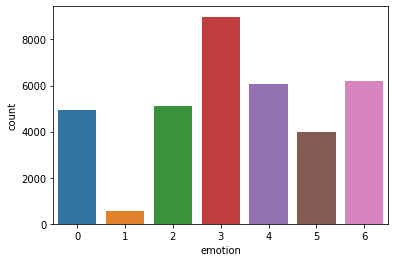

In [10]:
sns.countplot(df.emotion)
pyplot.show()

In [11]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

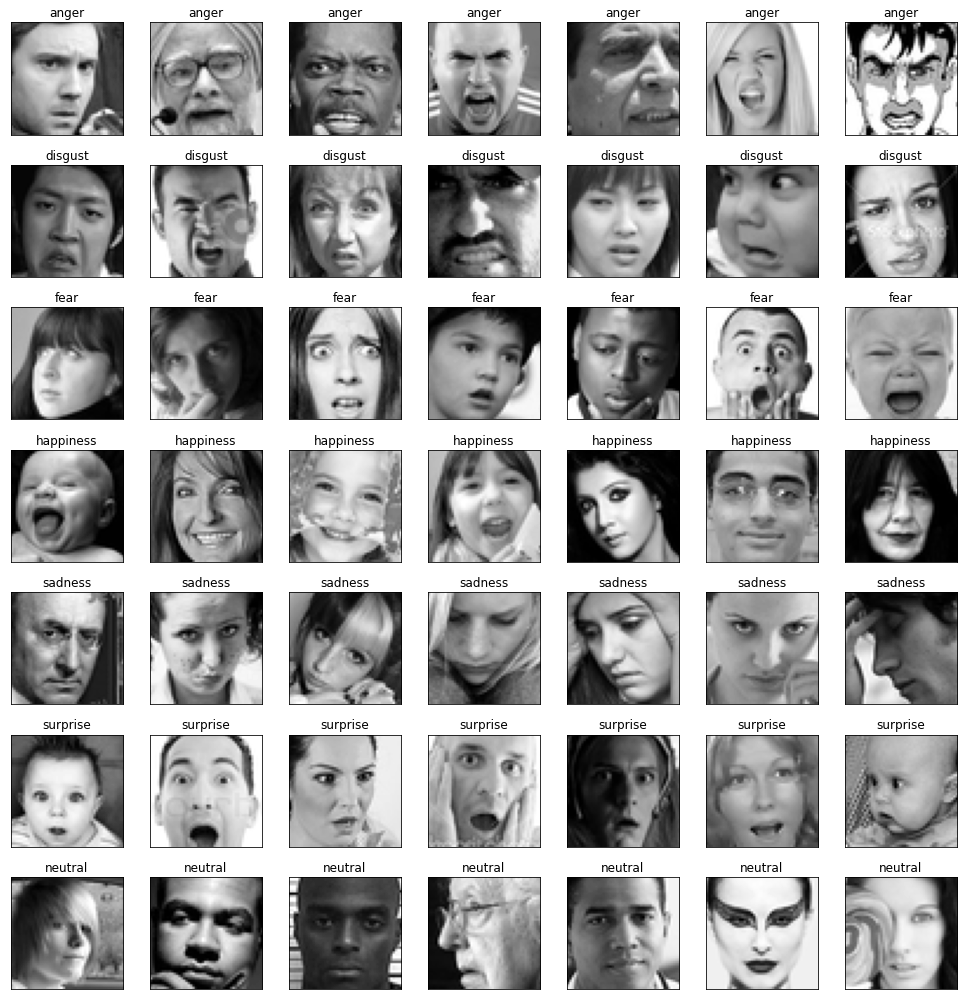

In [12]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [13]:
INTERESTED_LABELS = [3, 4, 6]

In [14]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

In [15]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [16]:
img_array.shape

(21264, 48, 48, 1)

In [17]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [18]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


`Splitting the data into training and validation set.`

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [20]:
del df
del img_array
del img_labels

In [21]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [22]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [23]:
def build_net(optim):
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [24]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def plot_feature_maps(model, image):
    # Expand dims if needed
    if image.ndim == 3:
        image = np.expand_dims(image, axis=0)

    # Normalize image if needed
    if image.max() > 1.0:
        image = image / 255.0

    # Extract convolutional layers and their outputs
    conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
    outputs = [layer.output for layer in conv_layers]
    activation_model = Model(inputs=model.input, outputs=outputs)

    # Get feature maps
    feature_maps = activation_model.predict(image)

    for i, fmap in enumerate(feature_maps):
        num_filters = fmap.shape[-1]
        grid_cols = 8
        grid_rows = int(np.ceil(num_filters / grid_cols))

        fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2, grid_rows * 2.2))
        fig.suptitle(f"Feature Maps - Conv Layer {i+1}", fontsize=18, y=1.02)

        for j in range(grid_rows * grid_cols):
            ax = axes[j // grid_cols, j % grid_cols]
            if j < num_filters:
                ax.imshow(fmap[0, :, :, j], cmap='viridis')
                ax.set_title(f"F{j+1}", fontsize=8)
            ax.axis('off')

        plt.tight_layout(pad=2.0)
        plt.subplots_adjust(top=0.9)  # Ensure title isn't overlapped
        plt.show()


In [26]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [27]:
batch_size = 32
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]


model = build_net(optims[1]) 
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        1664      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        102464    
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 48, 48, 64)        256       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 128)       73856  

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



599/598 [==============================] - 9s 15ms/step - loss: 0.4216 - accuracy: 0.8283 - val_loss: 0.4502 - val_accuracy: 0.8185
Epoch 57/100
599/598 [==============================] - 9s 15ms/step - loss: 0.4200 - accuracy: 0.8304 - val_loss: 0.4473 - val_accuracy: 0.8228
Epoch 58/100
599/598 [==============================] - 9s 15ms/step - loss: 0.4123 - accuracy: 0.8328 - val_loss: 0.4464 - val_accuracy: 0.8209
Epoch 59/100
599/598 [==============================] - 9s 15ms/step - loss: 0.4075 - accuracy: 0.8336 - val_loss: 0.4348 - val_accuracy: 0.8270
Epoch 67/100
598/598 [============================>.] - ETA: 0s - loss: 0.4095 - accuracy: 0.8332
Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
599/598 [==============================] - 9s 15ms/step - loss: 0.4095 - accuracy: 0.8332 - val_loss: 0.4597 - val_accuracy: 0.8148
Epoch 68/100
599/598 [==============================] - 9s 15ms/step - loss: 0.3971 - accuracy: 0.8435 - val_loss: 0.4443 -

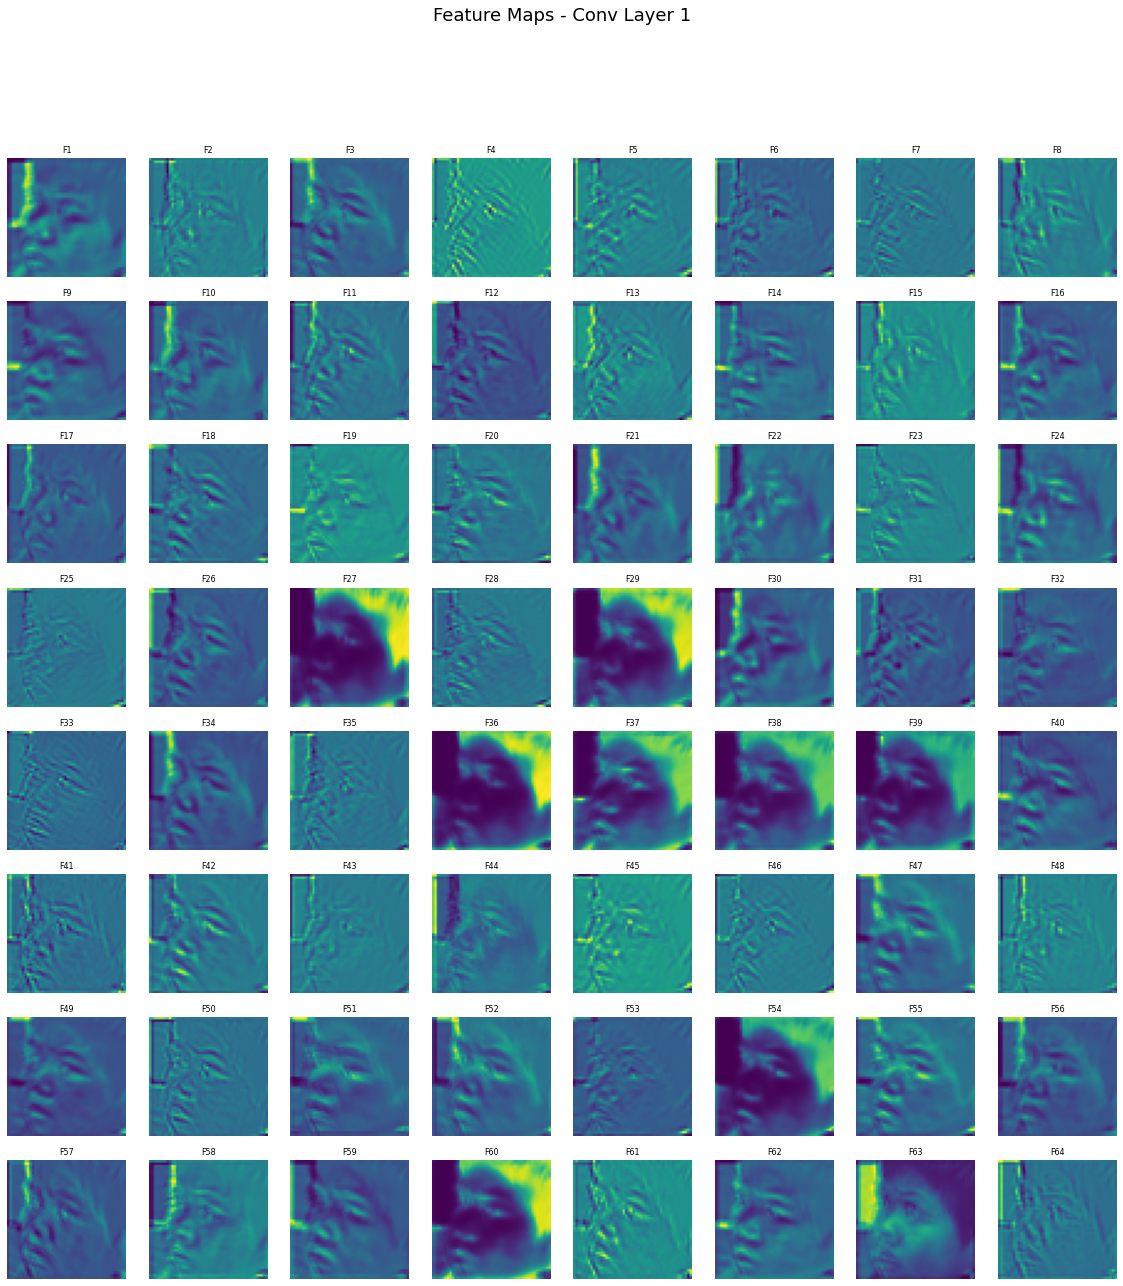

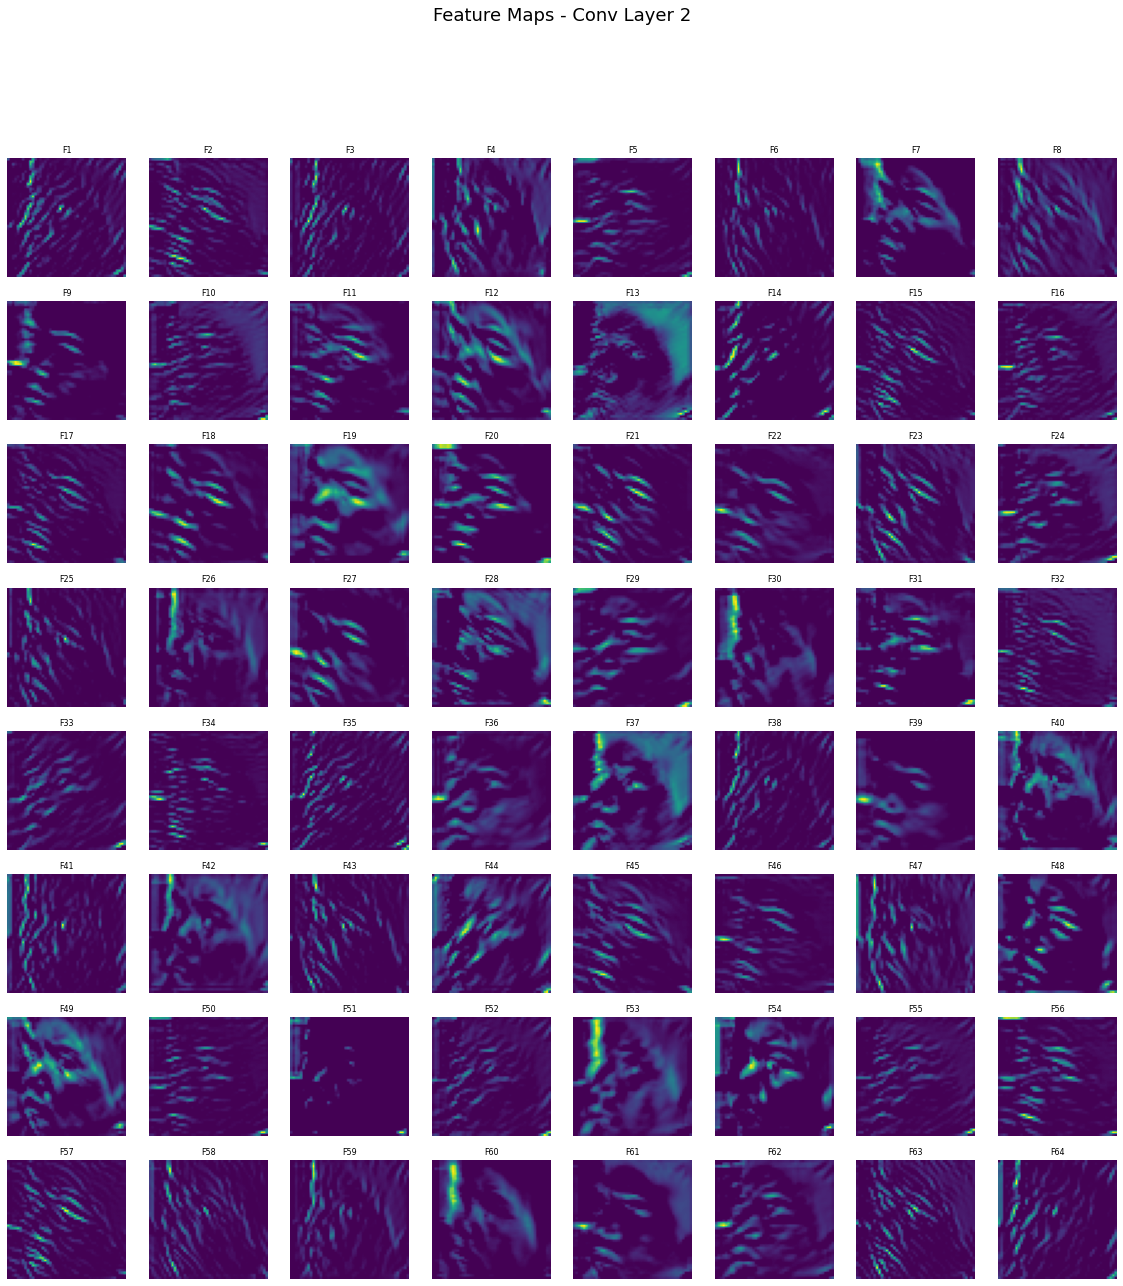

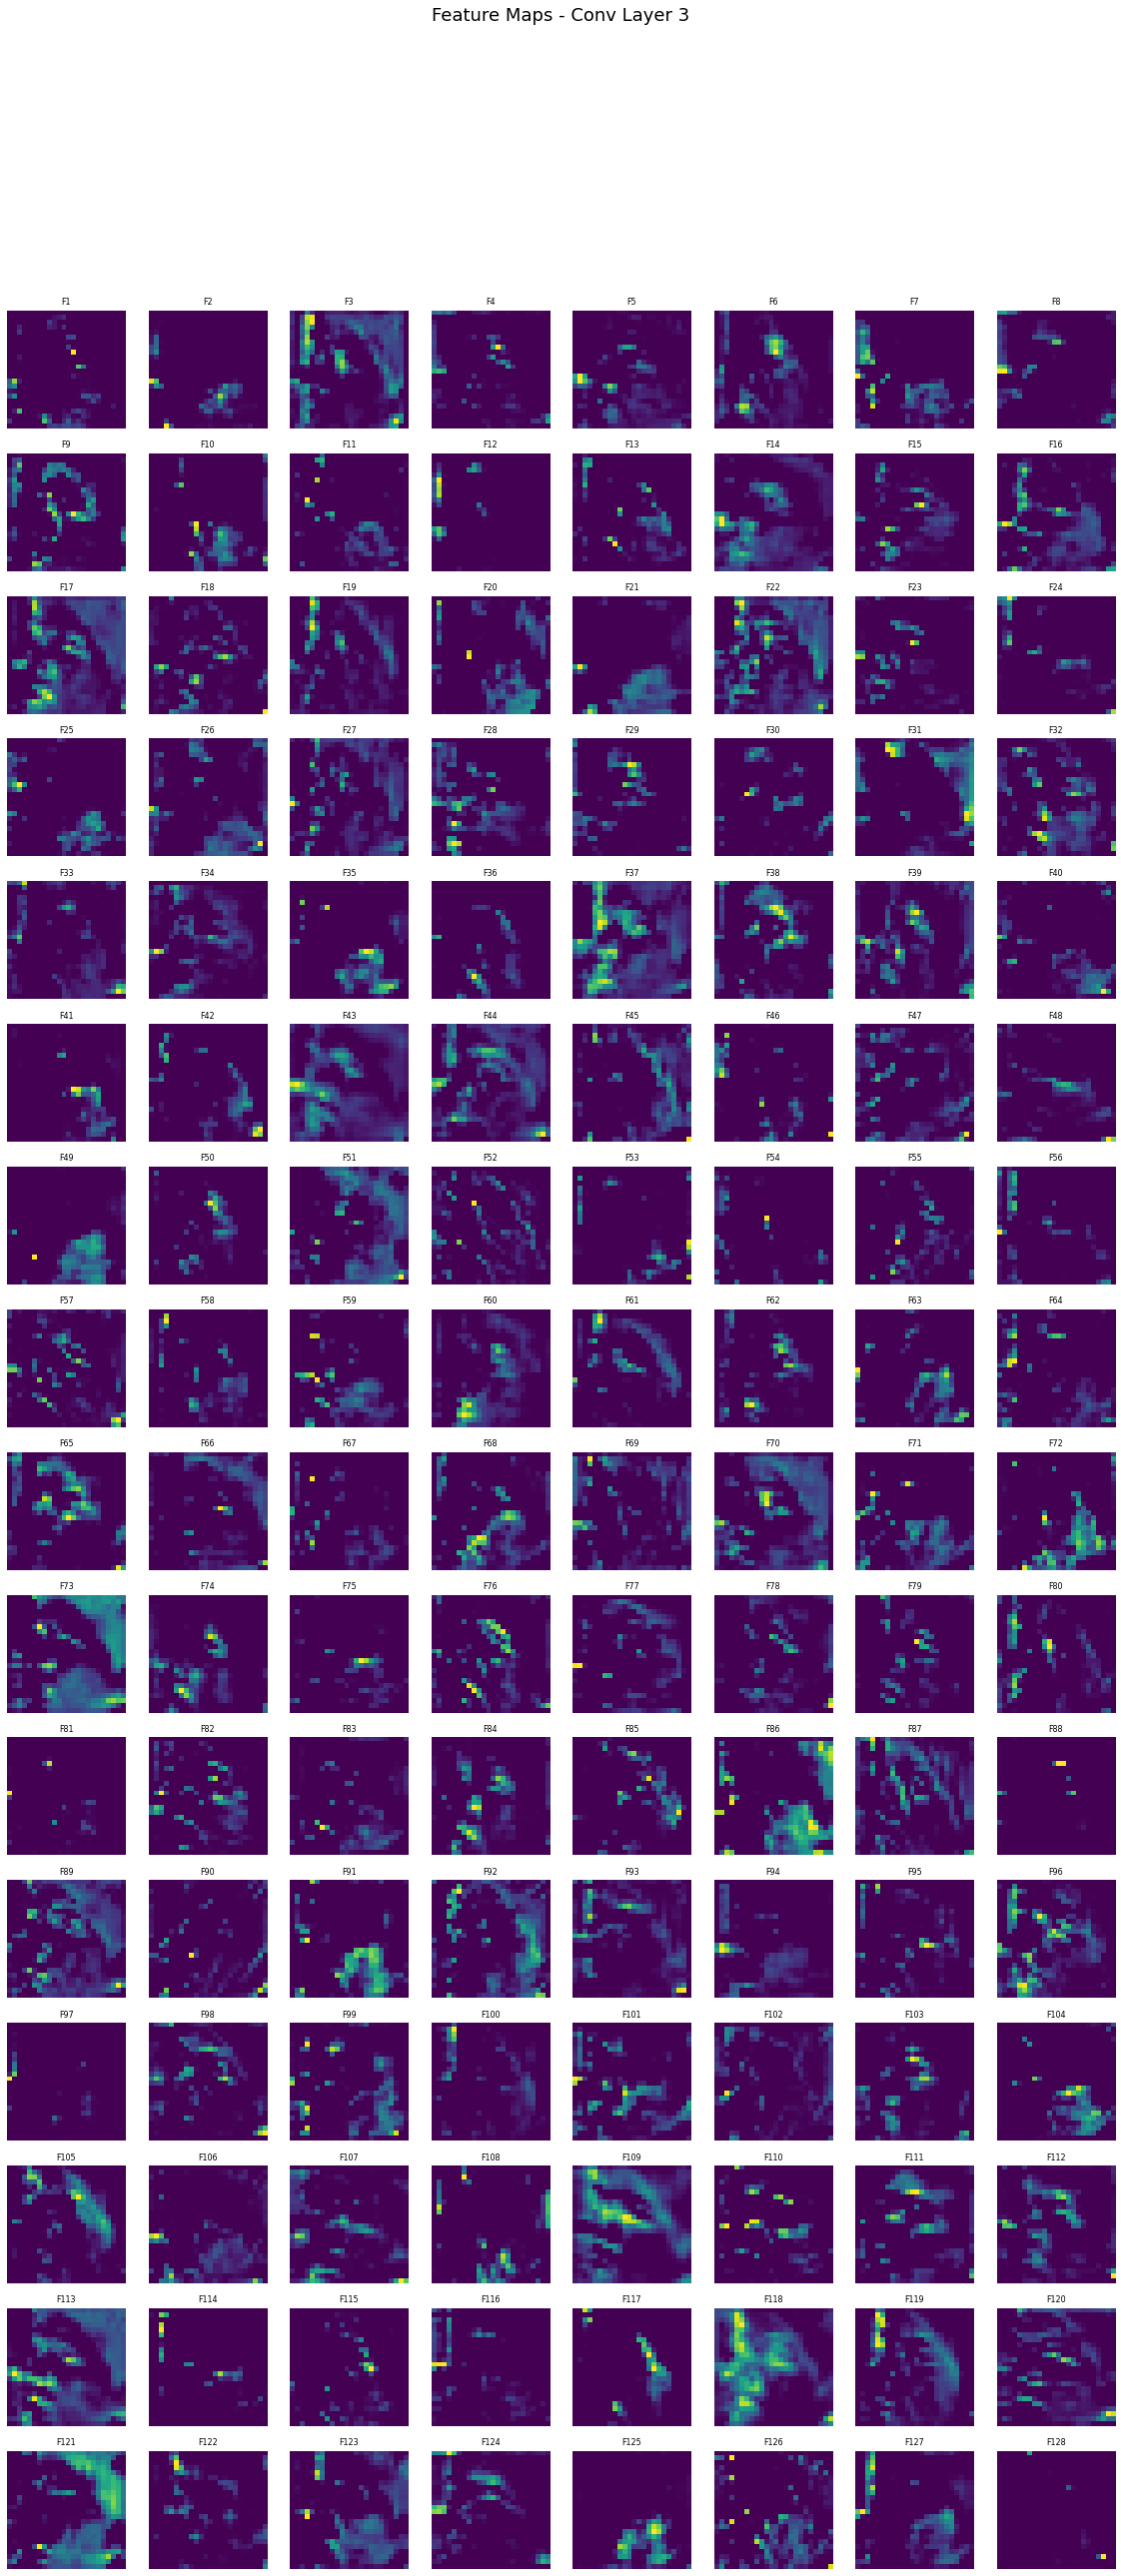

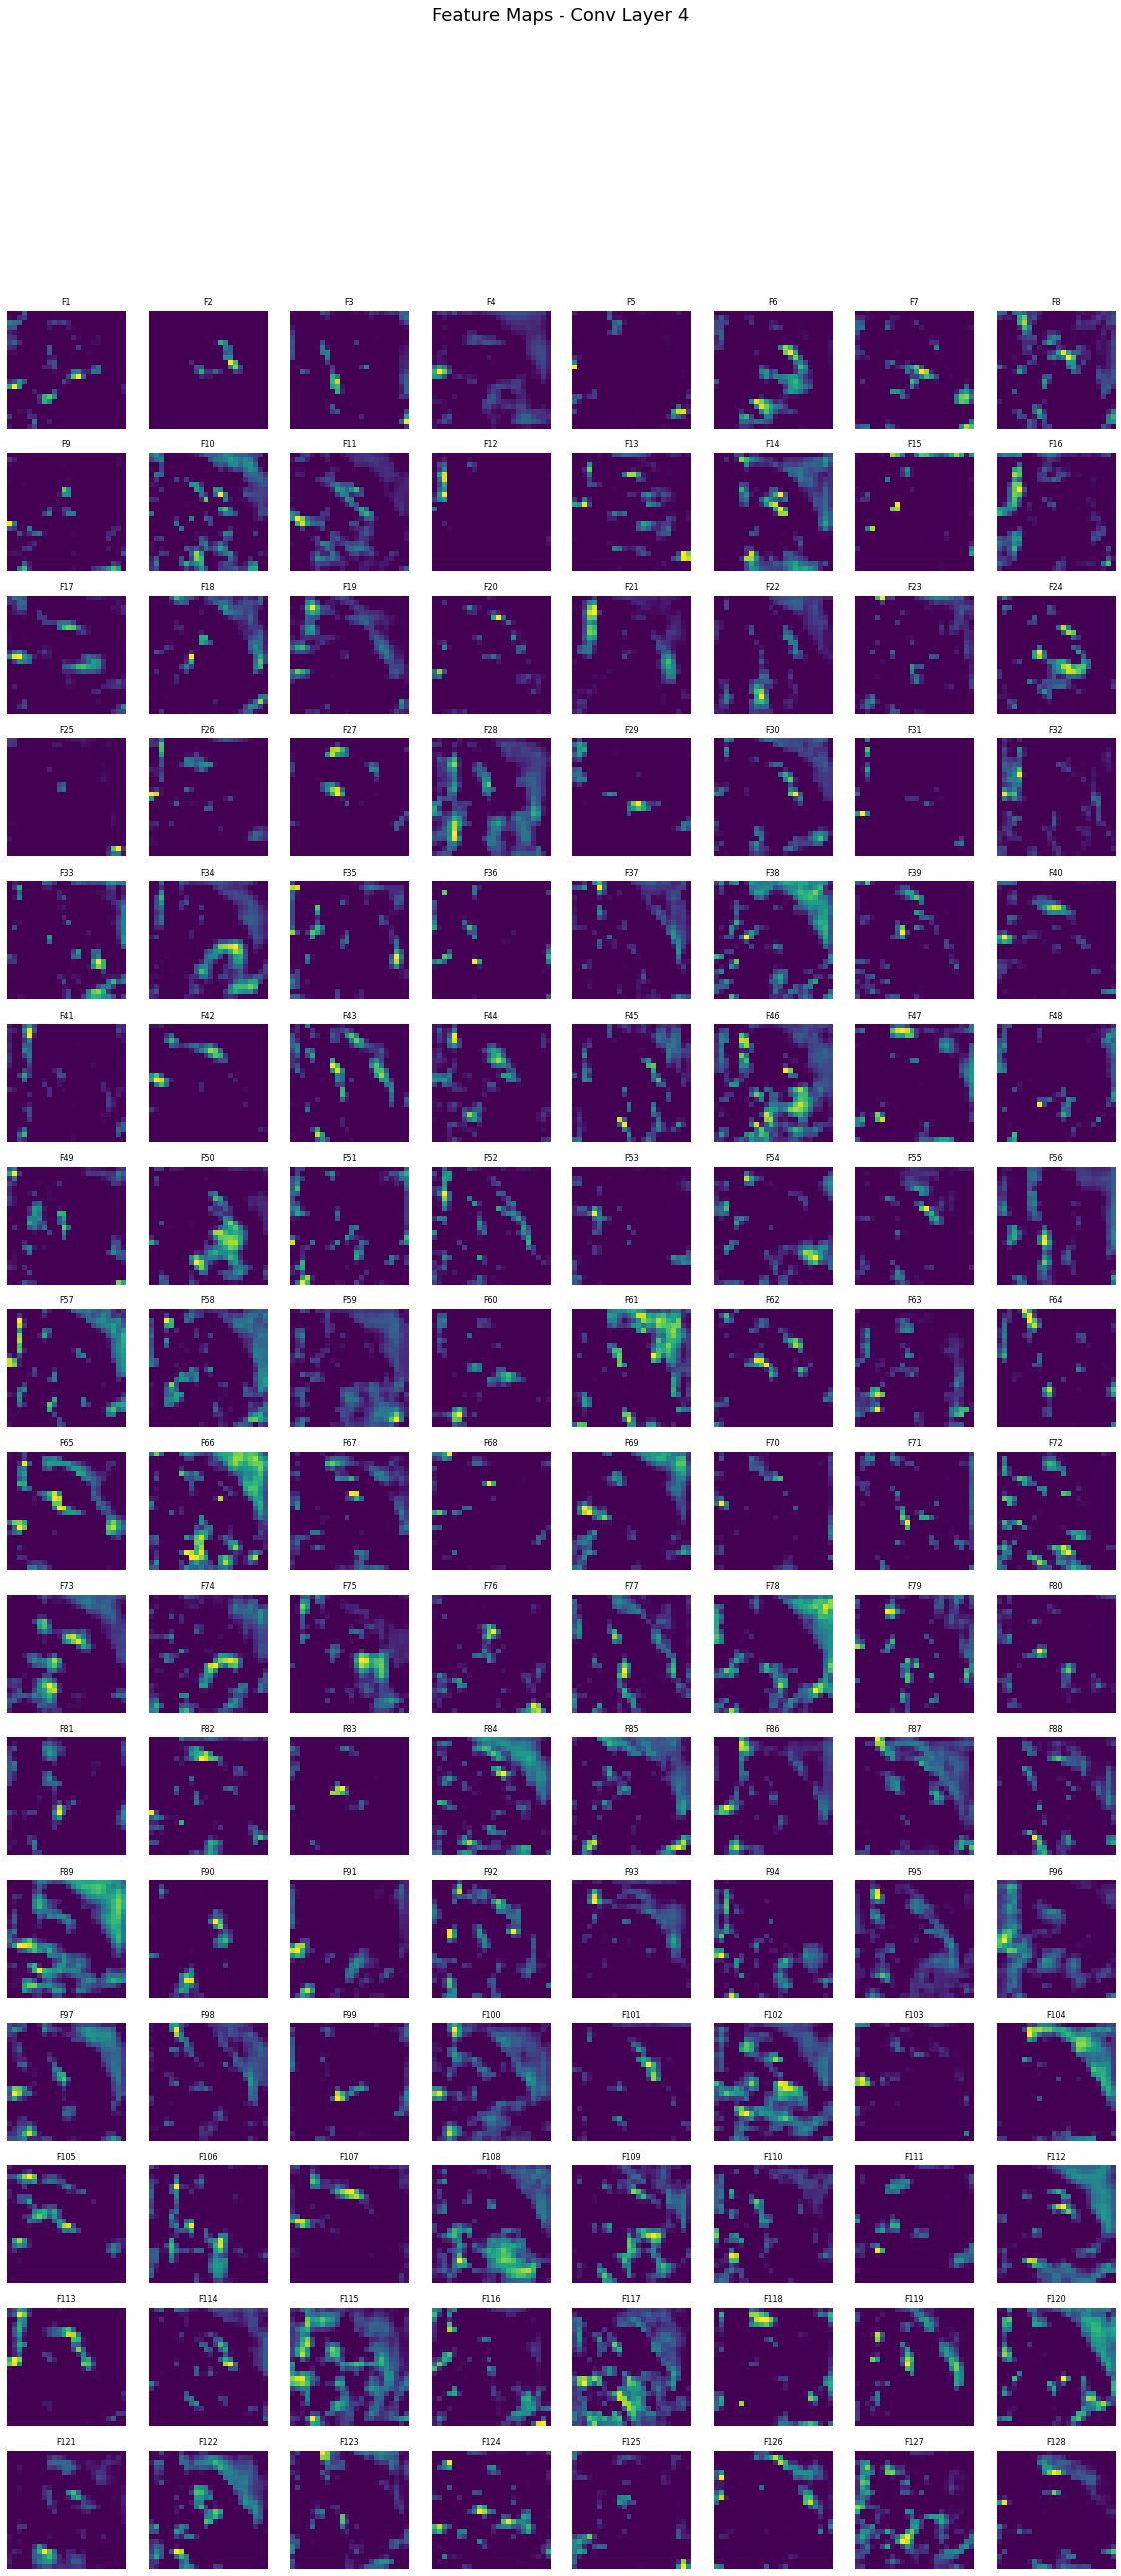

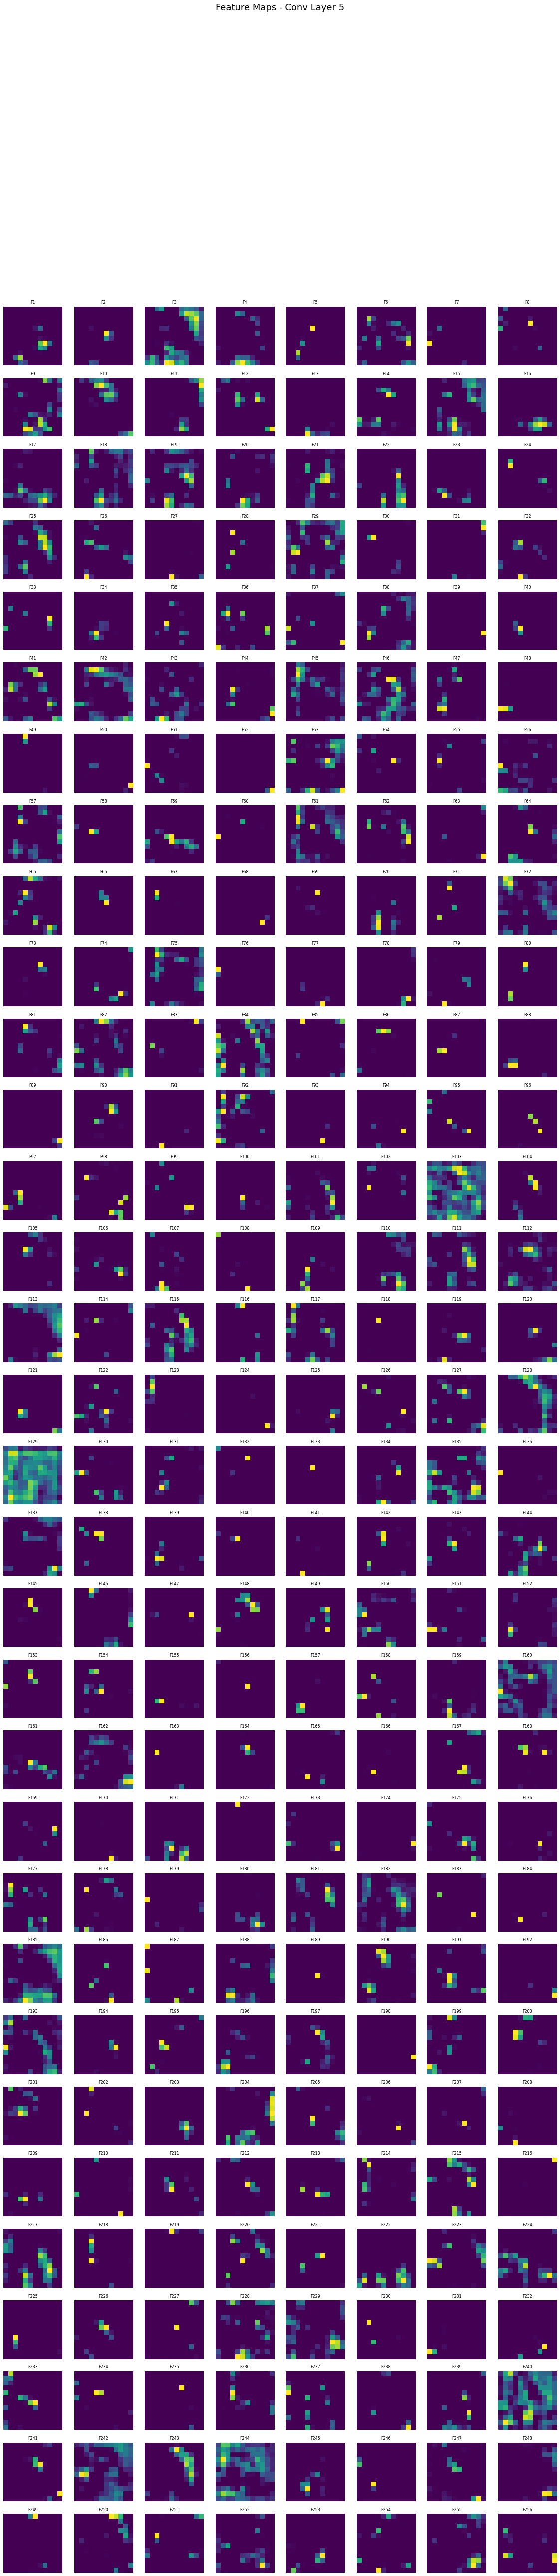

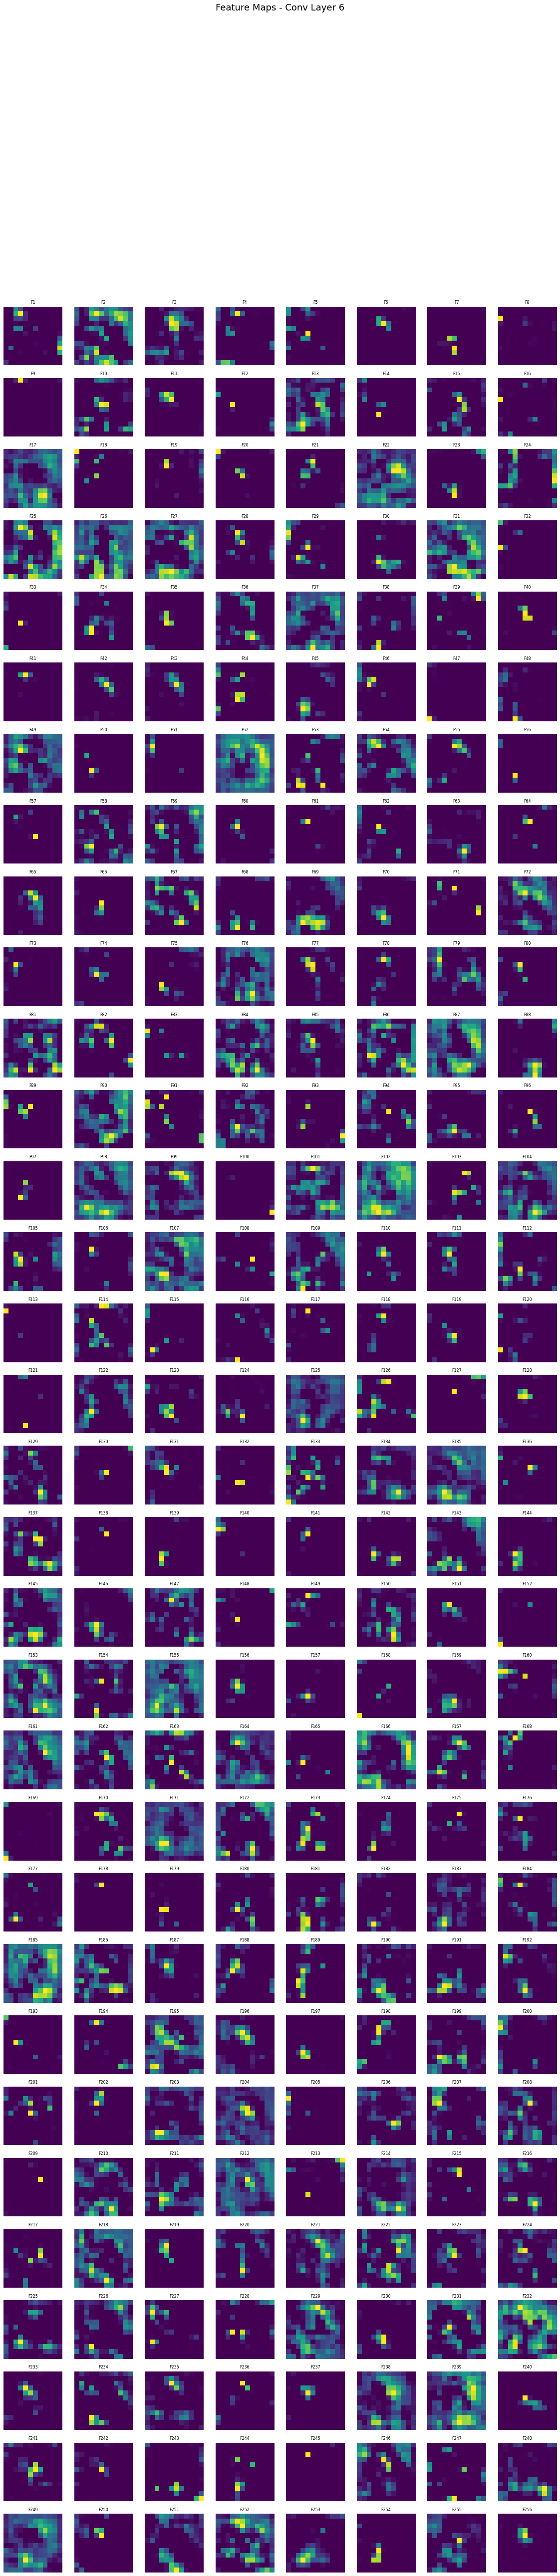

In [28]:
# Example to visualize
sample_img = X_valid[0]
plot_feature_maps(model, sample_img)


In [29]:
model_yaml = model.to_yaml()
with open("model.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("model.h5")

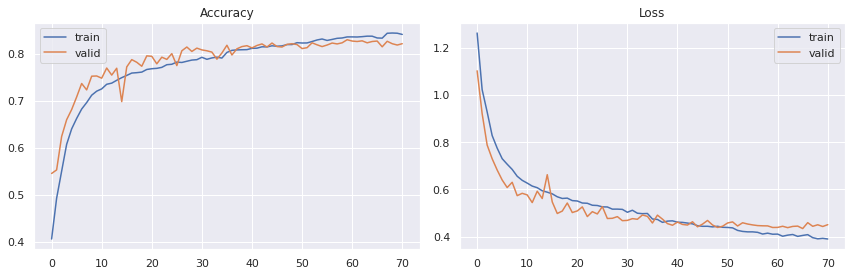

In [30]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

total wrong validation predictions: 362


              precision    recall  f1-score   support

           0       0.94      0.92      0.93       899
           1       0.77      0.76      0.77       608
           2       0.73      0.76      0.75       620

    accuracy                           0.83      2127
   macro avg       0.82      0.82      0.82      2127
weighted avg       0.83      0.83      0.83      2127



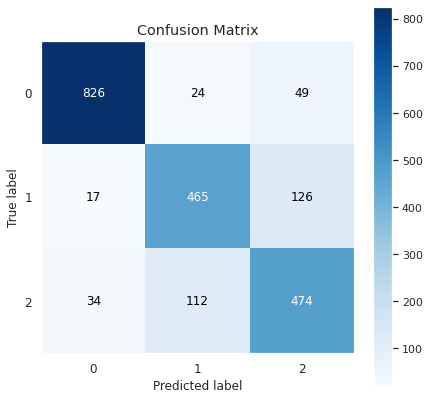

In [32]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

In [33]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

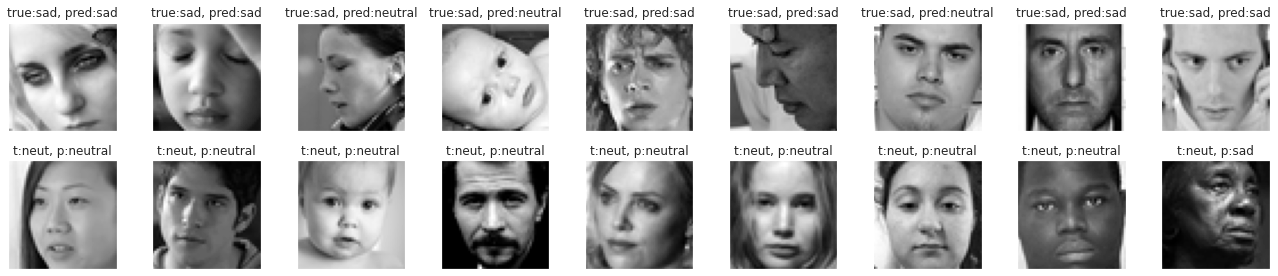

In [34]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"true:sad, pred:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"t:neut, p:{mapper[model.predict_classes(sample_img.reshape(1,48,48,1))[0]]}")

        pyplot.tight_layout()

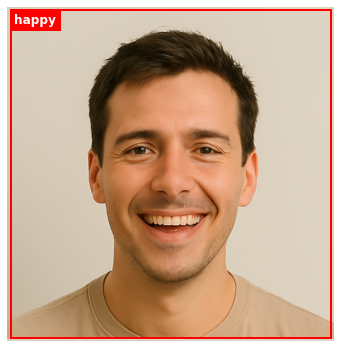

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.patches as patches

# Load the model
model = load_model('/kaggle/working/model.h5')

# Label mapping
emotion_label_to_text = {0: 'happy', 1: 'sad', 2: 'neutral'}

# Paths
img_path = '/kaggle/input/img-dataset-dl/img_test_1.png'

# Load original image (for display)
orig_img = load_img(img_path)  # RGB by default
orig_array = img_to_array(orig_img).astype("uint8")  # Shape (H, W, 3)

# Preprocess image for model (grayscale, 48x48)
gray_img = load_img(img_path, color_mode='grayscale', target_size=(48, 48))
gray_array = img_to_array(gray_img) / 255.0
gray_array = np.expand_dims(gray_array, axis=0)

# Predict
prediction = model.predict(gray_array)
predicted_class = np.argmax(prediction)
emotion = emotion_label_to_text[predicted_class]

# Plot original image with label
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(orig_array.astype('uint8'))

# Draw bounding box and label
height, width, _ = orig_array.shape
rect = patches.Rectangle((5, 5), width-10, height-10, linewidth=2,
                         edgecolor='red', facecolor='none')
ax.add_patch(rect)
ax.text(10, 25, f"{emotion}", color='white',
        fontsize=12, weight='bold', backgroundcolor='red')

ax.axis('off')
plt.tight_layout()
plt.show()


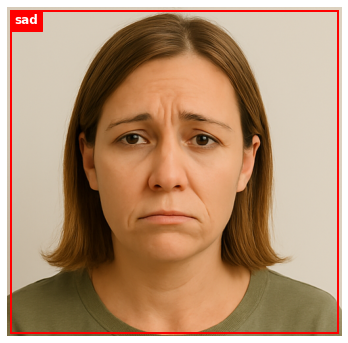

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.patches as patches

# Load the model
model = load_model('/kaggle/working/model.h5')

# Label mapping
emotion_label_to_text = {0: 'happy', 1: 'sad', 2: 'neutral'}

# Paths
img_path = '/kaggle/input/img-dataset-dl/img_test_4.png'

# Load original image (for display)
orig_img = load_img(img_path)  # RGB by default
orig_array = img_to_array(orig_img).astype("uint8")  # Shape (H, W, 3)

# Preprocess image for model (grayscale, 48x48)
gray_img = load_img(img_path, color_mode='grayscale', target_size=(48, 48))
gray_array = img_to_array(gray_img) / 255.0
gray_array = np.expand_dims(gray_array, axis=0)

# Predict
prediction = model.predict(gray_array)
predicted_class = np.argmax(prediction)
emotion = emotion_label_to_text[predicted_class]

# Plot original image with label
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(orig_array.astype('uint8'))

# Draw bounding box and label
height, width, _ = orig_array.shape
rect = patches.Rectangle((5, 5), width-10, height-10, linewidth=2,
                         edgecolor='red', facecolor='none')
ax.add_patch(rect)
ax.text(10, 25, f"{emotion}", color='white',
        fontsize=12, weight='bold', backgroundcolor='red')

ax.axis('off')
plt.tight_layout()
plt.show()


The predicted emotion is: happy


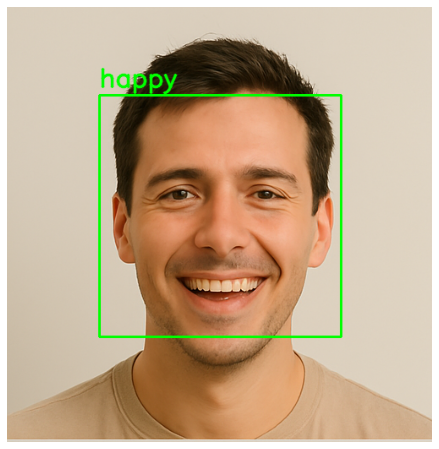

In [41]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/working/model.h5')  # Ensure the correct model path

# Emotion labels (only the 3 classes you used for training)
emotion_label_to_text = {0: 'happy', 1: 'sad', 2: 'neutral'}

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the image (color image for detection)
img_path = '/kaggle/input/img-dataset-dl/img_test_1.png'  # Update this path with your image path
img = cv2.imread(img_path)

# Convert to grayscale for the model and face detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Loop through the detected faces
for (x, y, w, h) in faces:
    # Extract the face region from the image
    face = img[y:y+h, x:x+w]

    # Preprocess the face for emotion detection (resize and grayscale)
    face_resized = cv2.resize(face, (48, 48))
    face_resized = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    face_resized = face_resized / 255.0  # Normalize the face

    # Convert to numpy array, reshape for the model
    face_array = np.expand_dims(face_resized, axis=0)  # Add batch dimension
    face_array = np.expand_dims(face_array, axis=-1)  # Add channel dimension (grayscale)
    
    # Make a prediction
    prediction = model.predict(face_array)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)
    emotion = emotion_label_to_text[predicted_class]

    # Draw a rectangle around the face
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle

    # Put the predicted emotion above the rectangle
    cv2.putText(img, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

# Print the result
print(f"The predicted emotion is: {emotion}")

# Convert the image from BGR (OpenCV format) to RGB (for display with Matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with the bounding box and emotion label
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()


The predicted emotion is: happy


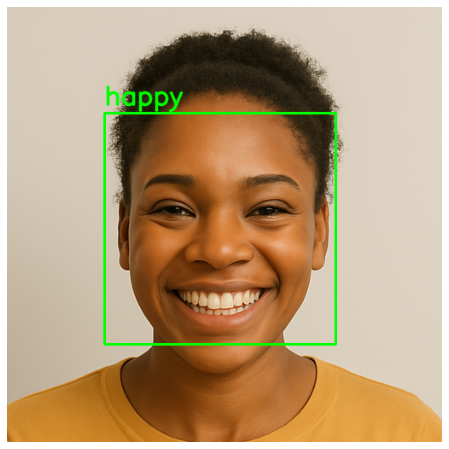

In [42]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/working/model.h5')  # Ensure the correct model path

# Emotion labels (only the 3 classes you used for training)
emotion_label_to_text = {0: 'happy', 1: 'sad', 2: 'neutral'}

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the image (color image for detection)
img_path = '/kaggle/input/img-dataset-dl/img_test_2.png'  # Update this path with your image path
img = cv2.imread(img_path)

# Convert to grayscale for the model and face detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Loop through the detected faces
for (x, y, w, h) in faces:
    # Extract the face region from the image
    face = img[y:y+h, x:x+w]

    # Preprocess the face for emotion detection (resize and grayscale)
    face_resized = cv2.resize(face, (48, 48))
    face_resized = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    face_resized = face_resized / 255.0  # Normalize the face

    # Convert to numpy array, reshape for the model
    face_array = np.expand_dims(face_resized, axis=0)  # Add batch dimension
    face_array = np.expand_dims(face_array, axis=-1)  # Add channel dimension (grayscale)
    
    # Make a prediction
    prediction = model.predict(face_array)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)
    emotion = emotion_label_to_text[predicted_class]

    # Draw a rectangle around the face
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle

    # Put the predicted emotion above the rectangle
    cv2.putText(img, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

# Print the result
print(f"The predicted emotion is: {emotion}")

# Convert the image from BGR (OpenCV format) to RGB (for display with Matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with the bounding box and emotion label
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()


The predicted emotion is: sad


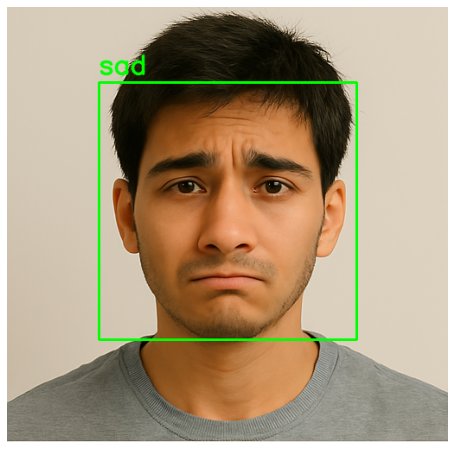

In [43]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/working/model.h5')  # Ensure the correct model path

# Emotion labels (only the 3 classes you used for training)
emotion_label_to_text = {0: 'happy', 1: 'sad', 2: 'neutral'}

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the image (color image for detection)
img_path = '/kaggle/input/img-dataset-dl/img_test_3.png'  # Update this path with your image path
img = cv2.imread(img_path)

# Convert to grayscale for the model and face detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Loop through the detected faces
for (x, y, w, h) in faces:
    # Extract the face region from the image
    face = img[y:y+h, x:x+w]

    # Preprocess the face for emotion detection (resize and grayscale)
    face_resized = cv2.resize(face, (48, 48))
    face_resized = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    face_resized = face_resized / 255.0  # Normalize the face

    # Convert to numpy array, reshape for the model
    face_array = np.expand_dims(face_resized, axis=0)  # Add batch dimension
    face_array = np.expand_dims(face_array, axis=-1)  # Add channel dimension (grayscale)
    
    # Make a prediction
    prediction = model.predict(face_array)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)
    emotion = emotion_label_to_text[predicted_class]

    # Draw a rectangle around the face
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle

    # Put the predicted emotion above the rectangle
    cv2.putText(img, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

# Print the result
print(f"The predicted emotion is: {emotion}")

# Convert the image from BGR (OpenCV format) to RGB (for display with Matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with the bounding box and emotion label
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()


The predicted emotion is: sad


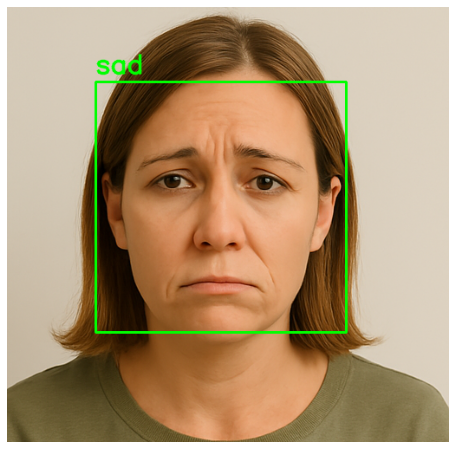

In [44]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/working/model.h5')  # Ensure the correct model path

# Emotion labels (only the 3 classes you used for training)
emotion_label_to_text = {0: 'happy', 1: 'sad', 2: 'neutral'}

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the image (color image for detection)
img_path = '/kaggle/input/img-dataset-dl/img_test_4.png'  # Update this path with your image path
img = cv2.imread(img_path)

# Convert to grayscale for the model and face detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Loop through the detected faces
for (x, y, w, h) in faces:
    # Extract the face region from the image
    face = img[y:y+h, x:x+w]

    # Preprocess the face for emotion detection (resize and grayscale)
    face_resized = cv2.resize(face, (48, 48))
    face_resized = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    face_resized = face_resized / 255.0  # Normalize the face

    # Convert to numpy array, reshape for the model
    face_array = np.expand_dims(face_resized, axis=0)  # Add batch dimension
    face_array = np.expand_dims(face_array, axis=-1)  # Add channel dimension (grayscale)
    
    # Make a prediction
    prediction = model.predict(face_array)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)
    emotion = emotion_label_to_text[predicted_class]

    # Draw a rectangle around the face
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle

    # Put the predicted emotion above the rectangle
    cv2.putText(img, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

# Print the result
print(f"The predicted emotion is: {emotion}")

# Convert the image from BGR (OpenCV format) to RGB (for display with Matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with the bounding box and emotion label
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()


The predicted emotion is: neutral


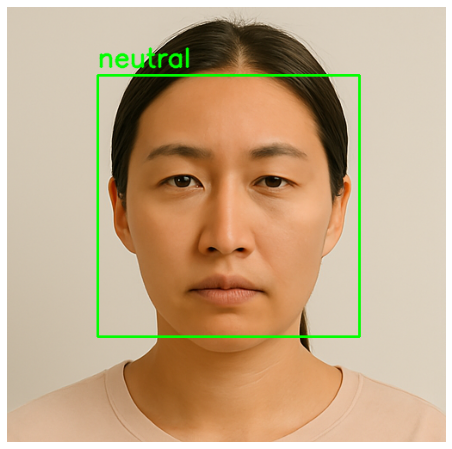

In [45]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/working/model.h5')  # Ensure the correct model path

# Emotion labels (only the 3 classes you used for training)
emotion_label_to_text = {0: 'happy', 1: 'sad', 2: 'neutral'}

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the image (color image for detection)
img_path = '/kaggle/input/img-dataset-dl/img_test_5.png'  # Update this path with your image path
img = cv2.imread(img_path)

# Convert to grayscale for the model and face detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Loop through the detected faces
for (x, y, w, h) in faces:
    # Extract the face region from the image
    face = img[y:y+h, x:x+w]

    # Preprocess the face for emotion detection (resize and grayscale)
    face_resized = cv2.resize(face, (48, 48))
    face_resized = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    face_resized = face_resized / 255.0  # Normalize the face

    # Convert to numpy array, reshape for the model
    face_array = np.expand_dims(face_resized, axis=0)  # Add batch dimension
    face_array = np.expand_dims(face_array, axis=-1)  # Add channel dimension (grayscale)
    
    # Make a prediction
    prediction = model.predict(face_array)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)
    emotion = emotion_label_to_text[predicted_class]

    # Draw a rectangle around the face
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle

    # Put the predicted emotion above the rectangle
    cv2.putText(img, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

# Print the result
print(f"The predicted emotion is: {emotion}")

# Convert the image from BGR (OpenCV format) to RGB (for display with Matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with the bounding box and emotion label
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()


The predicted emotion is: neutral


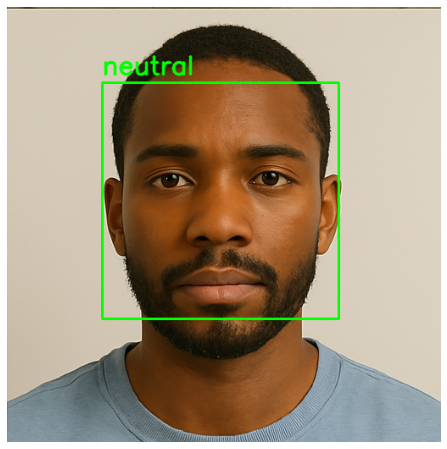

In [46]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/kaggle/working/model.h5')  # Ensure the correct model path

# Emotion labels (only the 3 classes you used for training)
emotion_label_to_text = {0: 'happy', 1: 'sad', 2: 'neutral'}

# Load the Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the image (color image for detection)
img_path = '/kaggle/input/img-dataset-dl/img_test_6.png'  # Update this path with your image path
img = cv2.imread(img_path)

# Convert to grayscale for the model and face detection
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

# Loop through the detected faces
for (x, y, w, h) in faces:
    # Extract the face region from the image
    face = img[y:y+h, x:x+w]

    # Preprocess the face for emotion detection (resize and grayscale)
    face_resized = cv2.resize(face, (48, 48))
    face_resized = cv2.cvtColor(face_resized, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    face_resized = face_resized / 255.0  # Normalize the face

    # Convert to numpy array, reshape for the model
    face_array = np.expand_dims(face_resized, axis=0)  # Add batch dimension
    face_array = np.expand_dims(face_array, axis=-1)  # Add channel dimension (grayscale)
    
    # Make a prediction
    prediction = model.predict(face_array)

    # Get the class with the highest probability
    predicted_class = np.argmax(prediction)
    emotion = emotion_label_to_text[predicted_class]

    # Draw a rectangle around the face
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangle

    # Put the predicted emotion above the rectangle
    cv2.putText(img, emotion, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

# Print the result
print(f"The predicted emotion is: {emotion}")

# Convert the image from BGR (OpenCV format) to RGB (for display with Matplotlib)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image with the bounding box and emotion label
plt.figure(figsize=(8, 8))
plt.imshow(img_rgb)
plt.axis('off')  # Turn off axis labels
plt.show()
